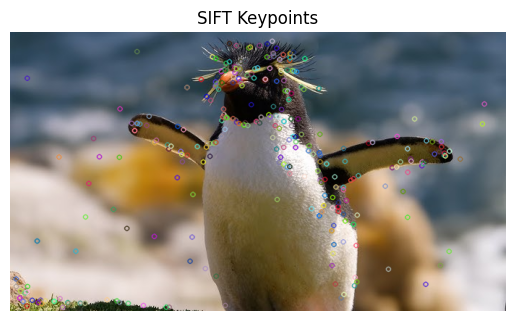

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('i3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)
img_sift = cv2.drawKeypoints(img, keypoints, None)
plt.imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
plt.title('SIFT Keypoints')
plt.axis('off')
plt.show()


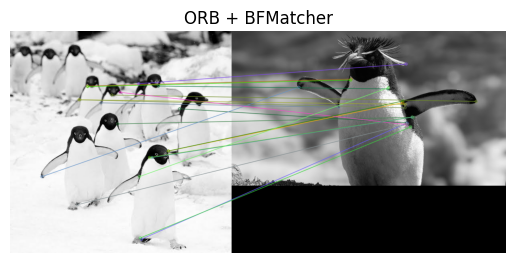

In [ ]:
img1 = cv2.imread('i2.jpeg', 0)
img2 = cv2.imread('i3.jpg', 0)
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
result = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
plt.imshow(result), plt.axis('off'), plt.title("ORB + BFMatcher")
plt.show()


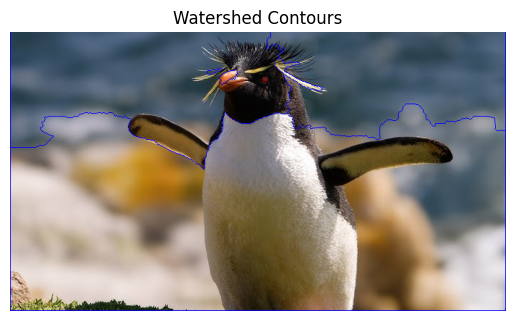

In [ ]:
import numpy as np
img = cv2.imread('i3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Watershed Contours")
plt.axis('off')
plt.show()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 127s 266ms/step - loss: 0.1177 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 262ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 258ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 260ms/step - loss: 0.1122 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 147s 271ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 137s 260ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 147s 272ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 138s 263ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 261ms/step - loss: 0.1120 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


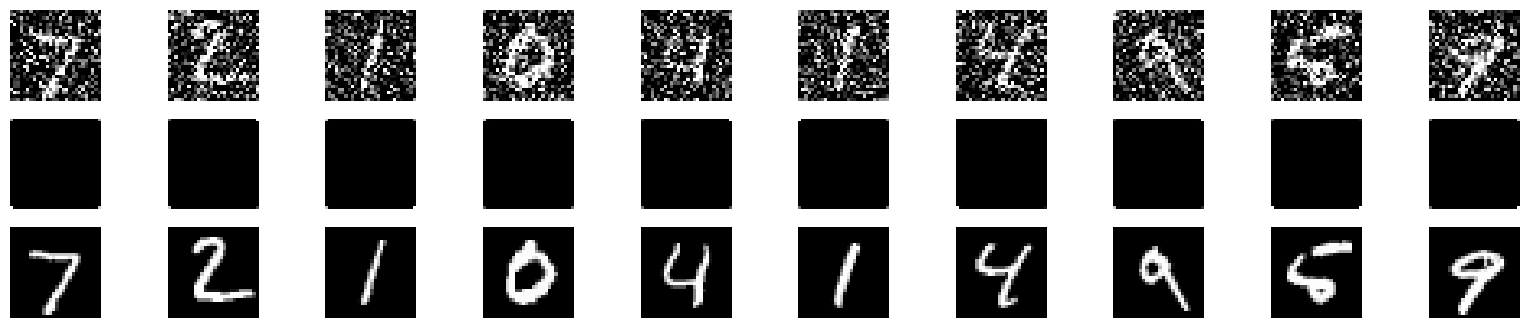

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Autoencoder Model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

# Evaluate
decoded_imgs = autoencoder.predict(x_test_noisy)

# Visualize
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')
plt.show()


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [ ]:
# MNIST
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_mnist, download=True)
mnist_loader = torch.utils.data.DataLoader(mnist, batch_size=128, shuffle=True)

# CIFAR-10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_cifar, download=True)
cifar_loader = torch.utils.data.DataLoader(cifar10, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 57.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.80MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.95MB/s]
100%|██████████| 170M/170M [00:02<00:00, 69.7MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 128, 7, 1, 0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
def train_gan(dataloader, generator, discriminator, num_epochs=50, nz=100, device='cuda'):
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    G_losses, D_losses = [], []

    for epoch in range(num_epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            b_size = real_imgs.size(0)

            # Real & Fake Labels
            real_labels = torch.ones(b_size, 1).to(device)
            fake_labels = torch.zeros(b_size, 1).to(device)

            # 1. Train Discriminator
            discriminator.zero_grad()
            output_real = discriminator(real_imgs).view(-1, 1)
            loss_real = criterion(output_real, real_labels)

            noise = torch.randn(b_size, nz, 1, 1).to(device)
            fake_imgs = generator(noise)
            output_fake = discriminator(fake_imgs.detach()).view(-1, 1)
            loss_fake = criterion(output_fake, fake_labels)

            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizerD.step()

            # 2. Train Generator
            generator.zero_grad()
            output_fake = discriminator(fake_imgs).view(-1, 1)
            loss_G = criterion(output_fake, real_labels)
            loss_G.backward()
            optimizerG.step()

        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    return G_losses, D_losses


In [ ]:
# Initialize
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nz = 100

# MNIST
netG_mnist = Generator(nz).to(device)
netD_mnist = Discriminator().to(device)
G_losses_mnist, D_losses_mnist = train_gan(mnist_loader, netG_mnist, netD_mnist, 50, nz, device)

# CIFAR-10 (need 3-channel model)
# Make similar Generator & Discriminator models that work with 3x32x32 and train


Epoch [1/50] | D Loss: 0.6192 | G Loss: 1.9388
Epoch [2/50] | D Loss: 0.4958 | G Loss: 1.9284
Epoch [3/50] | D Loss: 0.4594 | G Loss: 1.8660
Epoch [4/50] | D Loss: 0.7516 | G Loss: 2.8047
Epoch [5/50] | D Loss: 0.6276 | G Loss: 2.3606
Epoch [6/50] | D Loss: 0.6390 | G Loss: 1.8473
Epoch [7/50] | D Loss: 0.9080 | G Loss: 0.6875
Epoch [8/50] | D Loss: 0.5692 | G Loss: 2.1356
Epoch [9/50] | D Loss: 0.9374 | G Loss: 0.5588
Epoch [10/50] | D Loss: 0.5138 | G Loss: 2.6006
Epoch [11/50] | D Loss: 0.6227 | G Loss: 1.1740
Epoch [12/50] | D Loss: 0.6834 | G Loss: 1.0129
Epoch [13/50] | D Loss: 0.6997 | G Loss: 1.8534
Epoch [14/50] | D Loss: 0.5654 | G Loss: 1.9156
Epoch [15/50] | D Loss: 0.6598 | G Loss: 1.2629
Epoch [16/50] | D Loss: 0.5658 | G Loss: 1.7326
Epoch [17/50] | D Loss: 0.5974 | G Loss: 1.4178
Epoch [18/50] | D Loss: 1.0466 | G Loss: 3.2330
Epoch [19/50] | D Loss: 0.6049 | G Loss: 2.3363
Epoch [20/50] | D Loss: 0.6506 | G Loss: 3.2758
Epoch [21/50] | D Loss: 1.0745 | G Loss: 3.7446
E

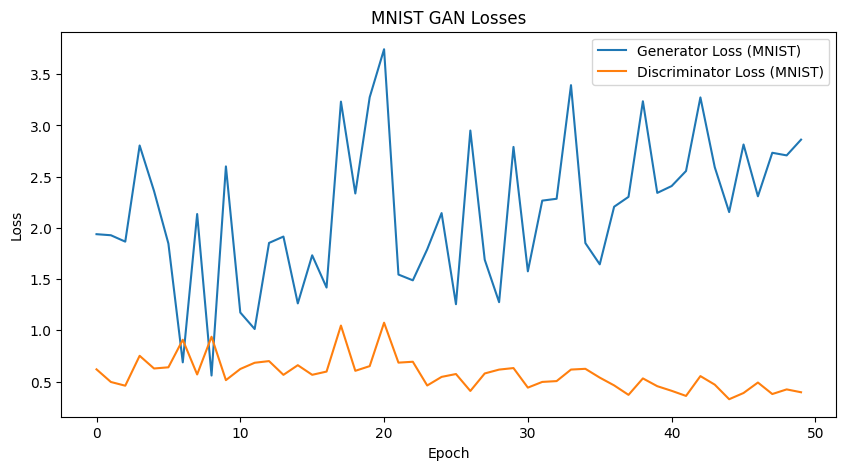

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(G_losses_mnist, label="Generator Loss (MNIST)")
plt.plot(D_losses_mnist, label="Discriminator Loss (MNIST)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("MNIST GAN Losses")
plt.show()
